In [1]:
import torch, torchvision, matplotlib

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor #ToTensor -- converts image data into a tensor

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True, #if False, loads the test data
    download=True, #downloads the MNIST dataset, not just loads it locally
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.34MB/s]


In [5]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [10]:
train_data.data #checking the data itself
train_data.data.shape #checking the size of the data

torch.Size([60000, 28, 28])

In [12]:
train_data.targets #checking the labels (outputs) of the training data
train_data.targets.shape #checking the size of the labels

torch.Size([60000])

In [13]:
from torch.utils.data import DataLoader #Loading the data in batches

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1), #num_workers specifies how many subprocesses to use for data loading; if 0, it happens in main process (used for data debugging)

    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1)
}

In [14]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x788e4d11fd10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x788e4d11c590>}

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__() #Calls the constructor of the parent class?

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d() #drops out/deactivates certain neurons in the layer
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x): #x is data
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320) #view is to flatten the output; 320=20*4*4
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training) #dropout is only triggered during training, not evaluation
    x = self.fc2(x)

    return F.softmax(x)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [19]:
def train(epoch):
  model.train()

  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() #Zeroing the gradients before starting each backprop
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

In [21]:
def test():
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad(): #disabling gradient, no backprop
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item() #comparing the predicted to the actual target and if true, summing it

  test_loss /= len(loaders['test'].dataset)
  print(f'\nTest set: Average Loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. *correct / len(loaders["test"].dataset):.0f}%\n)')

In [22]:
for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-16-bfe69c405935>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302036
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.305998
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.229107
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.034513
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.983213
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.851333
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.770956
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.802768
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.797330
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.659268
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.708373
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.668681
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.732095
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.638190
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.666607
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.749099
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.660009
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.641308
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.657038
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.607007
Train Epoch

In [23]:
device

device(type='cuda')

Prediction: 4


<ipython-input-16-bfe69c405935>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


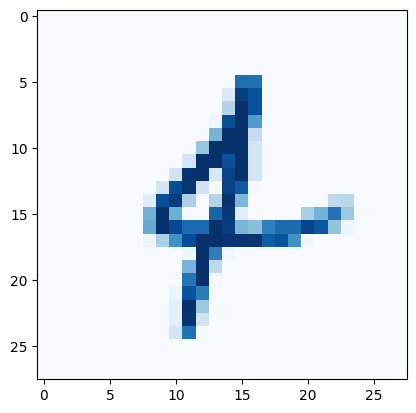

In [30]:
import matplotlib.pyplot as plt

model.eval()
data, target = test_data[300]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='Blues')
plt.show()